In [160]:
import os
import pandas as pd
import ptitprince as pt
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
import arviz as az
from systole.detection import oxi_peaks, rr_artefacts

sns.set_context('talk')

Import merged dataframe from behavioral data.

In [8]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
merged_df = pd.read_csv(path + '/data/merged.txt')
merged_df = merged_df[merged_df.Session == 'Del1']

Filter trial level dataframe, discretize confidence rating and store results in a `metacognition_trials.txt` file.

In [30]:
metacognition_df = pd.DataFrame([])
for sub in merged_df.Subject.unique():
    for cond in merged_df.Modality.unique():
        this_df = merged_df[(merged_df.Subject==sub) & (merged_df.Modality==cond)]
        
        # Drop NAs
        this_df = this_df[~this_df.Confidence.isnull()]

        # Discretize ratings
        try:
            new_ratings, out = discreteRatings(this_df.Confidence.to_numpy(), verbose=False)
            this_df.loc[:, 'Confidence'] = new_ratings
            metacognition_df = metacognition_df.append(this_df[['Subject', 'Modality', 'Alpha', 'Estimation', 'Confidence']])

        except ValueError:
            print(f'Dropping subject {sub} due to invalid ratings')
            
metacognition_df.columns = ['Subject', 'Condition', 'Stimuli', 'Estimation', 'Confidence']
metacognition_df.loc[:, 'Stimuli'] = metacognition_df['Stimuli'] > 0
metacognition_df.loc[:, 'Estimation'] = metacognition_df['Estimation'] == 'More'
metacognition_df['Accuracy'] = (metacognition_df['Stimuli'] & metacognition_df['Estimation']) | (~metacognition_df['Stimuli'] & ~metacognition_df['Estimation'])

metacognition_df.to_csv(path + '/data/metacognition_trials.txt')

Dropping subject sub_0245 due to invalid ratings


In [187]:
sdt_df = pd.DataFrame([])
to_R_df = pd.DataFrame([])
for sub in metacognition_df.Subject.unique():
    for cond in metacognition_df.Condition.unique():
        this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Condition==cond)]
        
        nR_S1, nR_S2 = trials2counts(
            data=this_df, stimuli='Stimuli', accuracy='Accuracy',
            confidence='Confidence', nRatings=4)
        nR_S1, nR_S2 = np.array(nR_S1), np.array(nR_S2)
        
        to_R_df = to_R_df.append(pd.DataFrame({'Subject': sub,
                                         'Condition': cond,
                                         'nR_S1': nR_S1,
                                         'nR_S2': nR_S2}))
        
        Tol = 1e-05
        nratings = int(len(nR_S1) / 2)

        # Adjust to ensure non-zero counts for type 1 d' point estimate
        adj_f = 1 / ((nratings) * 2)

        nR_S1_adj = nR_S1 + adj_f
        nR_S2_adj = nR_S2 + adj_f

        ratingHR, ratingFAR = [], []
        for c in range(1, int(nratings * 2)):
            ratingHR.append(sum(nR_S2_adj[c:]) / sum(nR_S2_adj))
            ratingFAR.append(sum(nR_S1_adj[c:]) / sum(nR_S1_adj))

        d1 = dprime(ratingHR[nratings - 1], ratingFAR[nratings - 1])
        c1 = criterion(ratingHR[nratings - 1], ratingFAR[nratings - 1])
        
        sdt_df = sdt_df.append(pd.DataFrame({'Subject': [sub],
                                             'Condition': [cond],
                                             'Accuracy': this_df.Accuracy.to_numpy().mean() * 100,
                                             'd': [d1],
                                             'c': [c1]}))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [188]:
to_R_df.to_csv('nRS.txt')

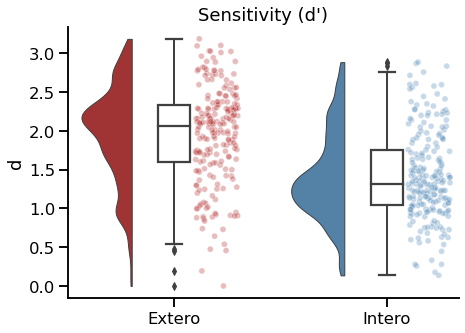

In [193]:
f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x='Condition', y='d', data=sdt_df, palette=['firebrick', 'steelblue'], bw=.2,
                    move=.2, width_viol=.5, ax=ax, orient='v', rain_linewidth=1, point_size=6, rain_alpha=.3)
ax.set_title('Sensitivity (d\')')
ax.set_ylabel('d')
ax.set_xlabel('')
sns.despine()
plt.savefig(path + '/figures/Fig3_dprime.svg', dpi=600)

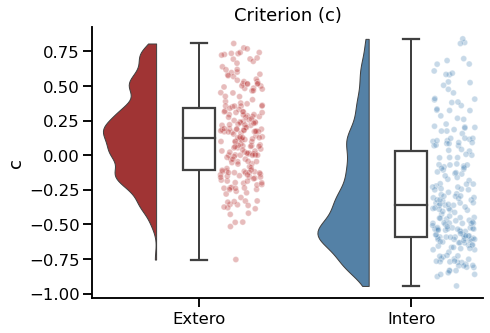

In [194]:
f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x='Condition', y='c', data=sdt_df, palette=['firebrick', 'steelblue'], bw=.2,
                    move=.2, width_viol=.5, ax=ax, orient='v', rain_linewidth=1, point_size=6, rain_alpha=.3)
ax.set_title('Criterion (c)')
ax.set_ylabel('c')
ax.set_xlabel('')
sns.despine()
plt.savefig(path + '/figures/Fig3_criterion.svg', dpi=600)

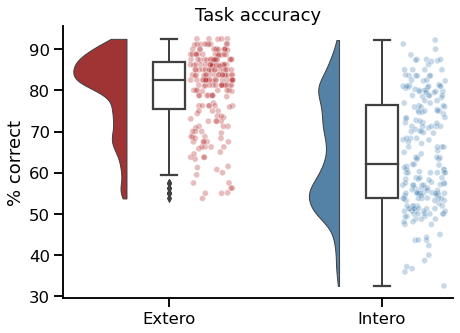

In [195]:
f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x='Condition', y='Accuracy', data=sdt_df, palette=['firebrick', 'steelblue'], bw=.2,
                    move=.2, width_viol=.5, ax=ax, orient='v', rain_linewidth=1, point_size=6, rain_alpha=.3)
ax.set_title('Task accuracy')
ax.set_ylabel('% correct')
ax.set_xlabel('')
sns.despine()
plt.savefig(path + '/figures/Fig3_accuracy.svg', dpi=600)

# Fitting hierarchical model using JAGS

In [50]:
samples = pd.read_csv('jagsSamples.txt', sep='\t')

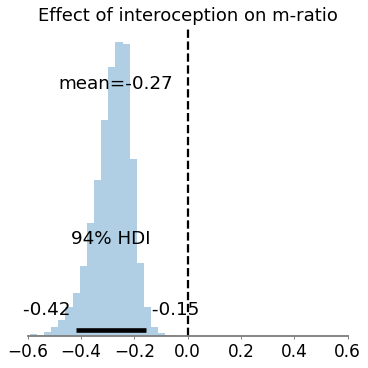

In [196]:
ax = az.plot_posterior(samples.value.to_numpy(), figsize=(5, 5), kind='hist', bins=20)
ax.axvline(x=0, linestyle='--', color='k')
ax.set_xlim(-.6, .6)
ax.set_title('Effect of interoception on m-ratio')
plt.savefig(path + '/figures/Fig3_betas.svg', dpi=600)

In [146]:
stats = pd.read_csv('jagsStats.txt', sep='\t')
stats['Condition'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Condition'] = 'Extero'
for sub in range(1, 217):
    stats.loc[stats.name.str.contains(str(sub)+','), 'Subject'] = [str(sub)]
stats = stats[stats.name.str.contains('Mratio')]

In [147]:
stats = stats[stats['mean'] < 10]

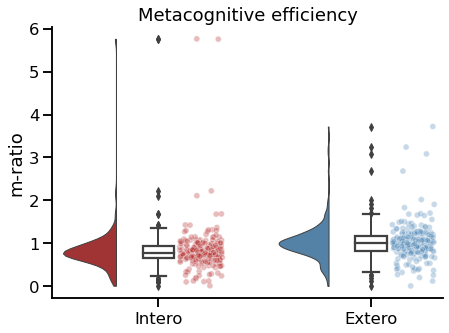

In [197]:
f, ax = plt.subplots(figsize=(7, 5))
ax=pt.RainCloud(x='Condition', y='mean', data=stats, palette=['firebrick', 'steelblue'], bw=.2,
                move = .2, width_viol=.5, ax=ax, orient='v', rain_linewidth=1, point_size=6, rain_alpha=.3)
ax.set_title('Metacognitive efficiency')
ax.set_ylabel('m-ratio')
ax.set_xlabel('')
sns.despine()
plt.savefig(path + '/figures/Fig3_mratio.svg', dpi=600)